<a href="https://colab.research.google.com/github/ApollocreedXI/Dashboard_H1B_Visa/blob/main/Final_Project_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you all have trouble running the code below, at least the file_path, you need to download the shared folder, and add it to "My Drive".

In [1]:
# we need these libraries.
import os
import altair as alt
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from statsmodels.api import OLS, add_constant
import warnings


# set pandas options for viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Final Project Time Series/Time Series Project Dataset-1.xlsx"

# Load into pandas
import pandas as pd
df = pd.read_excel(file_path)

# Convert Date to datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Final Project Time Series/Time Series Project Dataset-1.xlsx'

Note, I have not done the date adjustment he specified in class.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-09-08 to 2025-09-05
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SPY Price   2514 non-null   float64
 1   SPY Volume  2514 non-null   int64  
 2   % Change    2513 non-null   float64
 3   14-day RSI  2500 non-null   float64
 4   5-day SMA   2510 non-null   float64
 5   5-day EMA   2510 non-null   float64
 6   10-day SMA  2505 non-null   float64
 7   10-day EMA  2505 non-null   float64
 8   20-day SMA  2495 non-null   float64
 9   WTI Price   2502 non-null   float64
 10  VIX Price   2514 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 235.7 KB


In [ ]:
df.isna().sum()

,0
SPY Price,0
SPY Volume,0
% Change,1
14-day RSI,14
5-day SMA,4
5-day EMA,4
10-day SMA,9
10-day EMA,9
20-day SMA,19
WTI Price,12


In [ ]:
# Check for nulls only in rows AFTER the 20th row (index 20 onward)
nulls_after_20 = df.iloc[20:].isnull().sum()

print("Null counts after row 20:")
print(nulls_after_20)


Null counts after row 20:
SPY Price      0
SPY Volume     0
% Change       0
14-day RSI     0
5-day SMA      0
5-day EMA      0
10-day SMA     0
10-day EMA     0
20-day SMA     0
WTI Price     12
VIX Price      0
dtype: int64


So overall, there are not too many nulls or missingness in this dataset. Most are in the first 20 rows, as I believe the professor mentioned, there's a rolling window for some of the columns. Dropping the first 20 rows removes less than 1% of the data as we have 2,514 rows.

In [ ]:
total_rows = len(df)
drop_rows = 20

percent_dropped = (drop_rows / total_rows) * 100
print(f"Percentage dropped: {percent_dropped:.2f}%")
print("Less than 1%, shouldn't hurt anything, and I think we'd be better off")


Percentage dropped: 0.80%
Less than 1%, shouldn't hurt anything, and I think we'd be better off


Going to drop the first 20 rows.

In [ ]:
# Drop first 20 rows
df_clean = df.iloc[20:].copy()

In [ ]:
df_clean.isna().sum()

,0
SPY Price,0
SPY Volume,0
% Change,0
14-day RSI,0
5-day SMA,0
5-day EMA,0
10-day SMA,0
10-day EMA,0
20-day SMA,0
WTI Price,12


In [ ]:
# Show the rows with missing WTI Price
wti_null_rows = df[df['WTI Price'].isnull()]
print(wti_null_rows)


            SPY Price  SPY Volume  % Change  14-day RSI  5-day SMA  \
Date                                                                 
2017-07-03     242.21    39153810  0.001696   44.468085    242.036   
2018-11-23     263.25    42807880 -0.006679   38.072492    267.044   
2018-12-24     234.34   147311600 -0.026423   12.035629    245.710   
2018-12-31     249.92   143399900  0.008759   33.191670    245.252   
2019-07-05     298.46    51677330 -0.001138   72.335271    296.470   
2019-11-11     308.35    35934910 -0.001910   83.420463    307.920   
2020-11-27     363.67    28514070  0.002785   65.866122    360.468   
2021-11-26     458.97   112669600 -0.022303   56.405063    466.612   
2023-10-09     432.29    80374360  0.006402   32.032645    426.516   
2023-11-10     440.61    89558050  0.015605   63.506299    436.864   
2024-10-14     584.32    36217220  0.008178   62.760752    578.068   
2024-11-11     598.76    37586770  0.000953   63.245997    592.060   

             5-day 

In [ ]:
# Going to clean 'WTI Price' with interpolation, which is similar to forward-fill
df_clean['WTI Price'] = df['WTI Price'].interpolate(method='linear')

In [ ]:
df_clean.isna().sum()

,0
SPY Price,0
SPY Volume,0
% Change,0
14-day RSI,0
5-day SMA,0
5-day EMA,0
10-day SMA,0
10-day EMA,0
20-day SMA,0
WTI Price,0


Data looks clean now.

In [ ]:
# Spy series never had any nulls, but pulling it from df_clean to be organized I guess
spy_series = pd.Series(df_clean['SPY Price'].values, index=df_clean.index)
print(spy_series.head())


Date
2015-10-06    197.79
2015-10-07    199.41
2015-10-08    201.21
2015-10-09    201.33
2015-10-12    201.52
dtype: float64


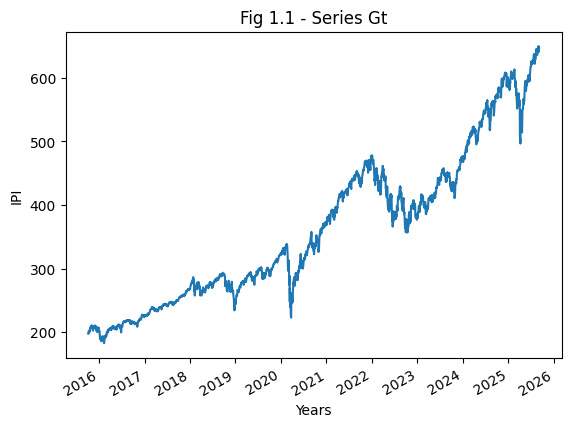

In [ ]:
spy_series.plot (title='Fig 1.1 - Series Gt', ylabel='IPI', xlabel='Years')
plt.show()